# Adult Income

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
%matplotlib inline

In [4]:
df = pd.read_hdf('train.adult.h5')

Check missing values in columns

In [5]:
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('Workclass', 1836)
('Occupation', 1843)
('Country', 583)


Insert these values with odd value

In [6]:
df = df.fillna(-100)

## Overall information

In [8]:
df.head(7)

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,True,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,True,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,True,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,False,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,False,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,False,0,0,16,Jamaica,<=50K


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int8
Workclass         32561 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education-Num     32561 non-null int64
Martial Status    32561 non-null object
Occupation        32561 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null bool
Capital Gain      32561 non-null int16
Capital Loss      32561 non-null int16
Hours per week    32561 non-null int8
Country           32561 non-null object
Target            32561 non-null object
dtypes: bool(1), int16(2), int64(2), int8(2), object(8)
memory usage: 2.9+ MB


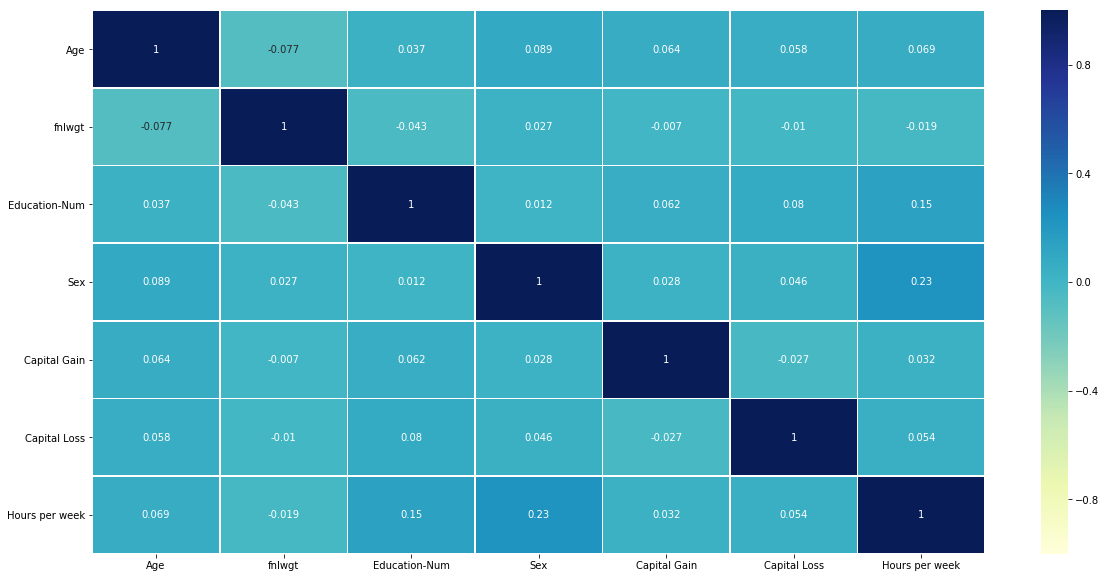

In [10]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(df.corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

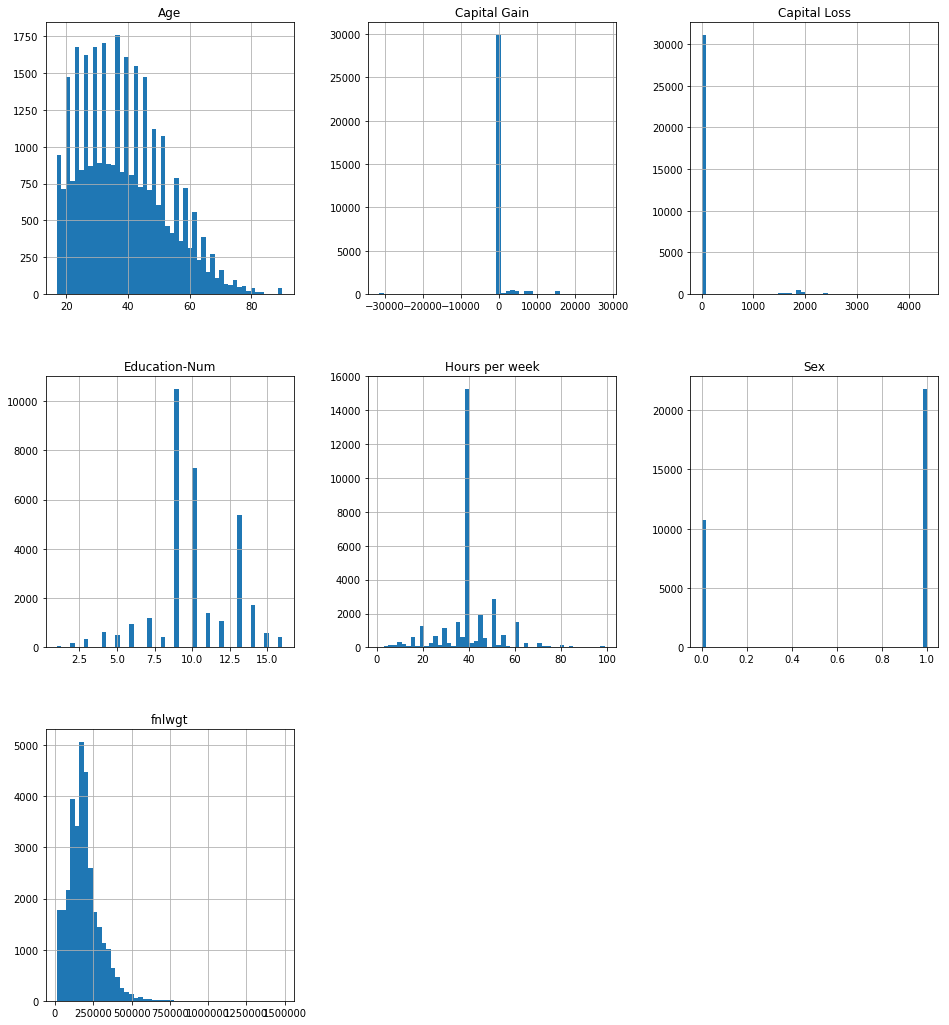

In [11]:
df.iloc[:,:25].hist(figsize=(16,18),bins=50);

In [12]:
pandas_profiling.ProfileReport(df)

Number of variables,15
Number of observations,32561
Total Missing (%),0.0%
Total size in memory,2.9 MiB
Average record size in memory,95.0 B
Numeric,6
Categorical,8
Boolean,1
Date,0
Text (Unique),0
Rejected,0


## Feature Engineering and Model Construction

In [17]:
#basic model function with dataset split into train and test parts

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 2000)
def train_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test,y_pred)

Following features were found gradually mainly on the basis of overall information from above

In [18]:
def education_func(level):
    if level in ['5th-6th', '10th', '1st-4th','12th','9th','11th','7th-8th','Some-college','Preschool']:
        return 1
    else:
        return 0
def country_func(country):
    if country in ['Cuba', 'Jamaica','Puerto-Rico', 'Honduras','Columbia','Ecuador','Haiti','Dominican-Republic', 'El-Salvador','Guatemala','Peru','Nicaragua']:
        return 1
    else:
        return 0

df['Target_cat'] = df['Target'].map(lambda x: int(x=='<=50K')).astype(np.int8)
df['Age_cat'] = pd.cut(df['Age'],5,labels = [0,1,2,3,4])
df['Age_cat'] = df['Age_cat'].astype(np.int8)
df['Age_25'] = df['Age'].map(lambda x: int(x<=20))
df['Capital Gain_binary'] = df['Capital Gain'].map(lambda x: int(x==0)).astype(np.int8)
df['Capital Loss_binary'] = df['Capital Loss'].map(lambda x: int(x==0)).astype(np.int8)
df['fnlwgt_cat'] = pd.cut(df['fnlwgt'],5,labels = [0,1,2,3,4])
df['fnlwgt_cat'] = df['fnlwgt_cat'].astype(np.int8)
df['fnlwgt_log'] = np.log(df['fnlwgt'])
df['Hours_per_week_less_binary'] = df['Hours per week'].map(lambda x: int(x<40)).astype(np.int8)
df['Hours_per_week_more_binary'] = df['Hours per week'].map(lambda x: int(x>40)).astype(np.int8)
df['Hours_per_week_40_binary'] = df['Hours per week'].map(lambda x: int(x==40)).astype(np.int8)
df['Education_cat'] = df['Education'].map(education_func)
df['Martial_Status_widowed'] = df['Martial Status'].map(lambda x: int(x=='Widowed')).astype(np.int8)
df['Martial_Status_not_married'] = df['Martial Status'].map(lambda x: int(x=='Never-married' or x == 'Separated' or x =='Widowed')).astype(np.int8)
df['Relationship_own_child'] = df['Relationship'].map(lambda x: int(x=='Own-child')).astype(np.int8)
df['Relationship_not_spouse'] = df['Relationship'].map(lambda x: int(x=='Not-in-family' or x == 'Unmarried' or x =='Other-relative')).astype(np.int8)
df['Race_white'] = df['Race'].map(lambda x: int(x=='White')).astype(np.int8)
df['Race_black'] = df['Race'].map(lambda x: int(x=='Black')).astype(np.int8)
df['Race_asian'] = df['Race'].map(lambda x: int(x=='Asian-Pac-Islander')).astype(np.int8)
df['Occupation_service'] = df['Occupation'].map(lambda x: int(x=='Other-service' or x == 'Protective-serv' or x =='Priv-house-serv')).astype(np.int8)
df['Country_SA'] = df['Country'].map(country_func).astype(np.int8)



In [20]:
features = ['Age_cat','Capital Gain_binary','Capital Gain','Capital Loss_binary','Capital Loss','Education-Num',\
            'Hours_per_week_less_binary','Martial_Status_not_married','Relationship_own_child','Relationship_not_spouse'\
           ,'Race_black','Education_cat','Race_asian','Age_25','Country_SA']

y = df['Target_cat']
X = df[features]


models = [LogisticRegression(),\
          RandomForestClassifier(),ExtraTreesClassifier(),\
         xgb.XGBClassifier(n_estimators=500),lgb.LGBMClassifier(n_estimators=100, random_state=2018),ctb.CatBoostClassifier(n_estimators=100, depth=10, verbose=False, random_state=2018)]

for model in models:
    print(model)
    print(train_predict(model, X_train, X_test, y_train, y_test))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.8343423707993332
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.8484688953233307
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_we

c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8611037992454155
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=2018,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8620689655172413
Learning rate set to 0.309221
0.8610160568570676


## Hyperopt for XGBoost Classifier

In [21]:
def objective(space):
    
    xgb_params = {
        'max_depth':int(space['max_depth']),
        'eta':space['eta'],
        'gamma':space['gamma'],
        'n_estimators':int(space['n_estimators']),
        'subsample':space['subsample'],
        'colsample_bytree':space['colsample_bytree'],
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda']
        
    }
    
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = 1 - accuracy_score(y_pred,y_test)
    
    print('Score: {0}'.format(score))
    return {'loss':score,'status':STATUS_OK}

space = {
    'max_depth':hp.quniform('x_max_depth',2,20,1),
    'eta':hp.uniform('eta',0.1,1),
    'gamma':hp.quniform('gamma',0,10,0.2),
    'n_estimators':hp.quniform('n_estimators',50,1000,5),
    'subsample':hp.uniform('subsample',0.5,1),
    'colsample_bytree':hp.uniform('colsample_bytree',0.5,1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.)
}

trials = Trials()
best_params = fmin(fn = objective,
                  space = space,
                  algo=partial(tpe.suggest, n_startup_jobs = 10),
                  max_evals = 50,
                  trials = trials)

print('Best params: ', best_params)

c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14266912345354044


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14231815390014912


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14249363867684484


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14082653329823636


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14275686584188818


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14152847240501887


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14240589628849698


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14468719838554


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14582784943406157


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13924717030797573


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13907168553128013


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13766780731771522


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13863297358954108


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14161621479336672


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13828200403614987


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14214266912345352


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13942265508467144


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13793103448275867


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13793103448275867


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13836974642449762


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13766780731771522


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13907168553128013


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13793103448275867


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14214266912345352


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13924717030797573


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.139159427919628


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.1393349126963236


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13828200403614987


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14196718434675792


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14135298762832327


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14205492673510578


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14196718434675792


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.1393349126963236


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.1429323506185839


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.139159427919628


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.1398613670264105


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14082653329823636


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13942265508467144


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.1405633061331929


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.1371413529876283


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13801877687110642


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14065104852154076


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14205492673510578


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.141440730016671


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14354654733701855


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.1432833201719751


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.1409142756865842


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.14152847240501887


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Score: 0.13907168553128013
Score: 0.14117750285162767
Best params:  {'colsample_bytree': 0.8613694669625604, 'eta': 0.9794419598638457, 'gamma': 0.8, 'n_estimators': 210.0, 'subsample': 0.9701904706780344, 'x_max_depth': 5.0, 'x_reg_alpha': 1.112307373912938, 'x_reg_lambda': 0.9068745396183641}


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Passing these parameters into the model:

In [24]:
model = xgb.XGBClassifier(colsample_bytree = 0.8613694669625604, learning_rate = 0.9794419598638457, gamma = 0.8, n_estimators = 210, subsample = 0.9701904706780344, max_depth = 5, reg_alpha = 1.112307373912938, x_reg_lambda = 0.9068745396183641)
print(train_predict(model, X_train, X_test, y_train, y_test))

0.8611037992454155


c:\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


This model reaches over 86% accuracy

## Feature Importance

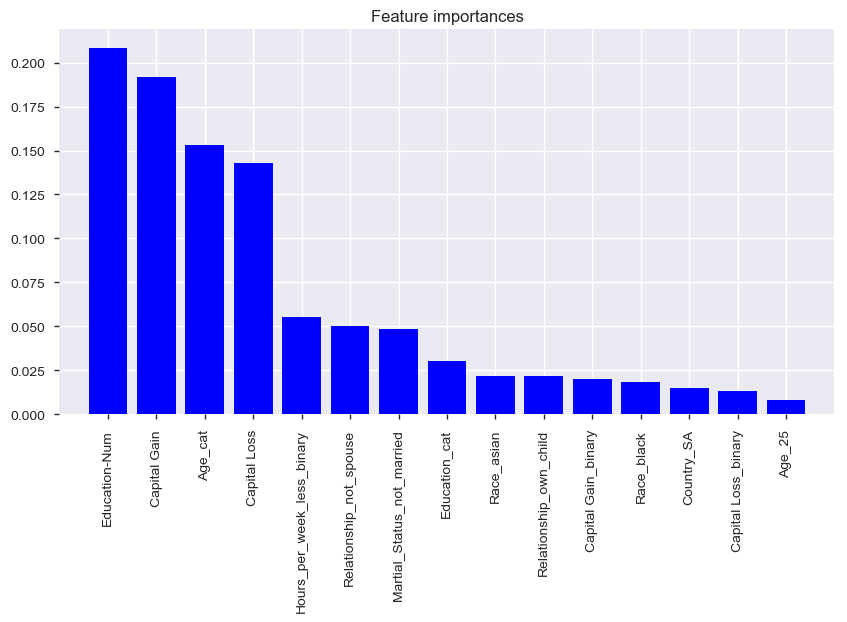

In [25]:
def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ features[x] for x in indices] )
    #plt.xticks(range(X.shape[1]), model.feature_importances_[indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()
model = xgb.XGBClassifier(colsample_bytree = 0.8613694669625604, learning_rate = 0.9794419598638457, \
                          gamma = 0.8, n_estimators = 210, subsample = 0.9701904706780344, max_depth = 5, \
                          reg_alpha = 1.112307373912938, x_reg_lambda = 0.9068745396183641)
model.fit(X, y)
draw_feature_importances(model, features)